# GONZAG WestMed example

This notebook demonstrates how you can blablabla

## Loading & initializations

In [1]:
import sys
from os import getenv

GONZAG_DIR   = getenv('HOME')+'/DEV/gonzag'
CLIMPORN_DIR = getenv('HOME')+'/DEV/climporn/python'

sys.path.append(GONZAG_DIR)

import gonzag as gz
from gonzag.config import ldebug

GONZAG_DATA_DIR = '/MEDIA/data/GONZAG/gonzag_input'

# Satellite input data:
file_sat = GONZAG_DATA_DIR+'/SENTINEL3A_20170130-20170303.nc'
name_ssh_sat = 'sla_unfiltered'

# Model input data:
file_mod = GONZAG_DATA_DIR+'/sossheig_box_WestMed_eNATL60-BLBT02_20170201-20170228.nc'
name_ssh_mod = 'sossheig'
file_lsm_mod = file_mod; name_lsm_mod = '_FillValue' ; # we use _FillValue attribute of "nams_ssh_mod" in "file_mod"
l_griddist = False ; # grid is not strongly distorded





### Time overlap between model and satellite data ?

In [2]:
    (it1,it2), (Nts,Ntm) = gz.GetEpochTimeOverlap( file_sat , file_mod )
    print(' *** Time overlap between model and satellite in UNIX epoch time: it1, it2', it1,'--',it2)
    print('   => UTC: "'+gz.EpochT2Str(it1)+'" to "'+gz.EpochT2Str(it2)+'"\n')


 *** Time overlap between model and satellite in UNIX epoch time: it1, it2 1485909000.0 -- 1488324600.0
   => UTC: "Wed Feb  1 00:30:00 2017" to "Tue Feb 28 23:30:00 2017"



## Create object `ModelGrid` containing all the model (aka _source_) 2D+T domain grid info

In [3]:
    clsm = name_lsm_mod
    if name_lsm_mod=='_FillValue': clsm = name_lsm_mod+'@'+name_ssh_mod
    
    ModelGrid = gz.ModGrid( file_mod, it1, it2, file_lsm_mod, clsm, distorded_grid=l_griddist )



 *** what we use to define model land-sea mask:
    => "_FillValue@sossheig" in "/MEDIA/data/GONZAG/gonzag_input/sossheig_box_WestMed_eNATL60-BLBT02_20170201-20170228.nc"

 *** Skipping computation of angle distortion of the model grid! ("-D" option not invoked)...

 *** About model gridded (source) domain:
     * shape =  (796, 868)
     * horizontal resolution:  0.016753984549605475  degrees or  1.8615352233066644  km
     * Is this a global domain w.r.t longitude:  False
       ==> this is a regional domain
       ==> working in the [-180:180] frame...
     * lon_min, lon_max =  -5.5 9.53
     * lat_min, lat_max =  34.91 45.1
     * should we pay attention to possible STRONG local distorsion in the grid:  False
     * number of time records of interest for the interpolation to come:  672
       ==> time record indices: 0 to 671, included



## Create object `SatelliteTrack` containing all the satellite track (aka _target_) info

In [4]:
SatelliteTrack = gz.SatTrack( file_sat, it1, it2, Np=Nts, \
                              domain_bounds=ModelGrid.domain_bounds, l_0_360=ModelGrid.l360 )

 *** [SatTrack()] Analyzing the time vector in /MEDIA/data/GONZAG/gonzag_input/SENTINEL3A_20170130-20170303.nc ...

 *** About satellite track (target) domain:
     * number of time records of interest for the interpolation to come:  2452
       ==> time record indices: 95570 to 1410931, included



## Build the bilinear mapping & Perform the space-time interpolation

In [5]:
Solution = gz.Model2SatTrack( ModelGrid, name_ssh_mod, SatelliteTrack, name_ssh_sat )

 *** "found" distance criterion when searching for nearest point on model grid is  1.3961514174799983  km

 *** Will use zoom boxes of width of 269 points for 1st attempts of nearest-point location...


 *** Finding nearest points on source (model) grid... (rd_found_km, np_box_r = 1.3961514174799983 134 )
      +++ Treated point: 245/2452 
          ==> Sat. coordinates:     39.966 2.321
          ==> Model nearest point:  39.963 2.32  ( 388 459 )
      +++ Treated point: 490/2452 
          ==> Sat. coordinates:     41.698 3.973
          ==> Model nearest point:  41.697 3.98  ( 536 552 )
      +++ Treated point: 735/2452 
          ==> Sat. coordinates:     44.73 -2.725
          ==> Model nearest point:  44.729 357.279  ( 771 142 )
      +++ Treated point: 980/2452 
          ==> Sat. coordinates:     37.188 3.302
          ==> Model nearest point:  37.192 3.303  ( 169 524 )
      +++ Treated point: 1225/2452 
          ==> Sat. coordinates:     42.166 5.873
          ==> Model near

/home/laurent/DEV/gonzag/gonzag/bilin_mapping.py:108: RuntimeWarning: invalid value encountered in double_scalars
  zdalp = nmp.linalg.det( zM ) / zdeta
/home/laurent/DEV/gonzag/gonzag/bilin_mapping.py:111: RuntimeWarning: invalid value encountered in double_scalars
  zdbet = nmp.linalg.det( zM ) / zdeta


     ***    Done! *** 


 *** Starting space-time interpolation of model data onto the 2452 selected track points...
      jt = 00000 => satelite time = Wed Feb  1 09:56:04 2017
      jt = 00245 => satelite time = Sat Feb  4 10:19:43 2017
      jt = 00490 => satelite time = Sun Feb  5 21:13:09 2017
      jt = 00735 => satelite time = Wed Feb  8 21:36:27 2017
      jt = 00980 => satelite time = Sun Feb 12 10:13:02 2017
      jt = 01225 => satelite time = Thu Feb 16 10:07:52 2017
      jt = 01470 => satelite time = Sun Feb 19 10:31:56 2017
      jt = 01715 => satelite time = Tue Feb 21 20:57:57 2017
      jt = 01960 => satelite time = Fri Feb 24 10:01:04 2017
      jt = 02205 => satelite time = Mon Feb 27 10:24:18 2017
      jt = 02450 => satelite time = Tue Feb 28 21:16:50 2017
 *** Space-time interpolation done!


 *** Time report:
     - Construction of the source-target bilinear mapping took: 35.0 s
     - Interpolation of model data on the 2452 satellite points took: 11.0 s 




## Object `Solution` contains everything you need to start the plots and the science... 

### 1/ Plot the nearest points on the model domain

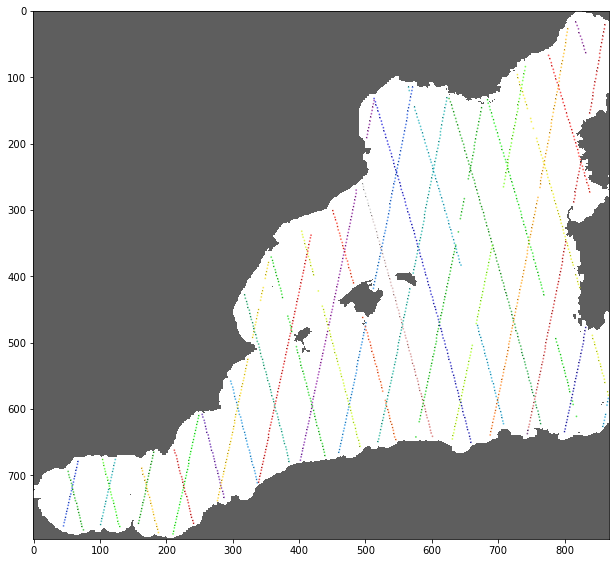

In [6]:
import numpy as nmp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#
#sys.path.append(CLIMPORN_DIR)
#from climporn import chose_colmap
#
%matplotlib inline

XFLD = nmp.flipud(Solution.XNPtrack)
(Nj,Ni) = XFLD.shape
(idy,idx) = nmp.where( XFLD > 0 )

XMSK = nmp.flipud(Solution.XNPmask)
pmsk = nmp.ma.masked_where(XMSK[:,:]<0.1, XMSK[:,:]*0.7)


fig = plt.figure(num = 1, figsize=(8,8*Nj/Ni), facecolor='w', edgecolor='k')
ax  = plt.axes([0., 0., 1., 1.],     facecolor = 'w')
norm_fld = colors.Normalize(vmin =nmp.amin(XFLD[(idy,idx)]), vmax=nmp.amax(XFLD[(idy,idx)]), clip = False)
cf = ax.scatter(idx, idy, c=XFLD[(idy,idx)], cmap = 'nipy_spectral', norm = norm_fld, alpha=0.5, marker='.', s=3 )
#
norm_lsm = colors.Normalize(vmin = 0., vmax = 1., clip = False)
cm = ax.imshow(pmsk, cmap='Greys', norm=norm_lsm, interpolation='none')
